In [1]:
from keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import numpy as np

import os

Using TensorFlow backend.


In [2]:
model = load_model('models/unet_no_drop.h5')

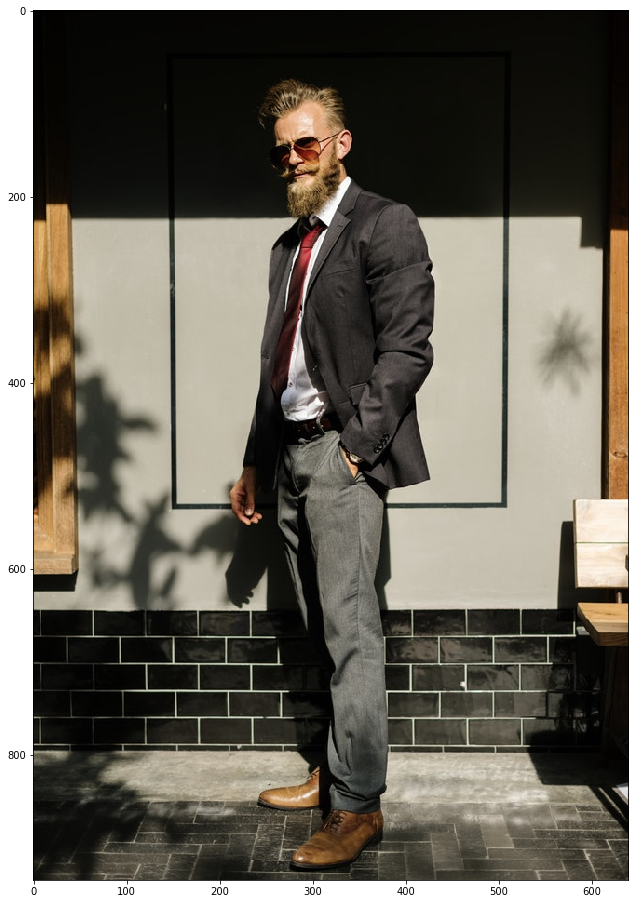

In [88]:
IMG_PATH = 'imgs/04.jpg'

img = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
img_ori = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 16))
plt.imshow(img_ori)

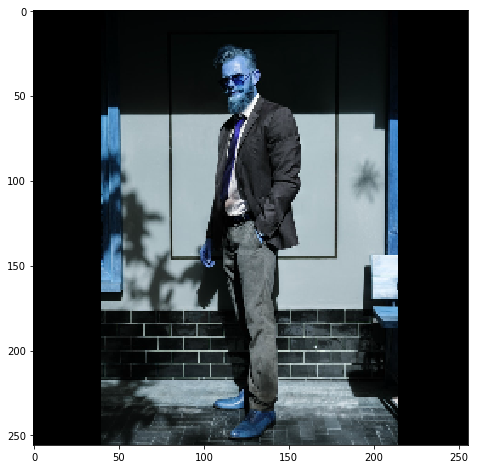

In [89]:
IMG_WIDTH, IMG_HEIGHT = 256, 256

def preprocess(img):
    im = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.uint8)

    if img.shape[0] >= img.shape[1]:
        scale = img.shape[0] / IMG_HEIGHT
        new_width = int(img.shape[1] / scale)
        diff = (IMG_WIDTH - new_width) // 2
        img = cv2.resize(img, (new_width, IMG_HEIGHT))

        im[:, diff:diff + new_width, :] = img
    else:
        scale = img.shape[1] / IMG_WIDTH
        new_height = int(img.shape[0] / scale)
        diff = (IMG_HEIGHT - new_height) // 2
        img = cv2.resize(img, (IMG_WIDTH, new_height))

        im[diff:diff + new_height, :, :] = img
        
    return im

img = preprocess(img)

plt.figure(figsize=(8, 8))
plt.imshow(img)

In [90]:
input_img = img.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3)).astype(np.float32) / 255.

pred = model.predict(input_img)

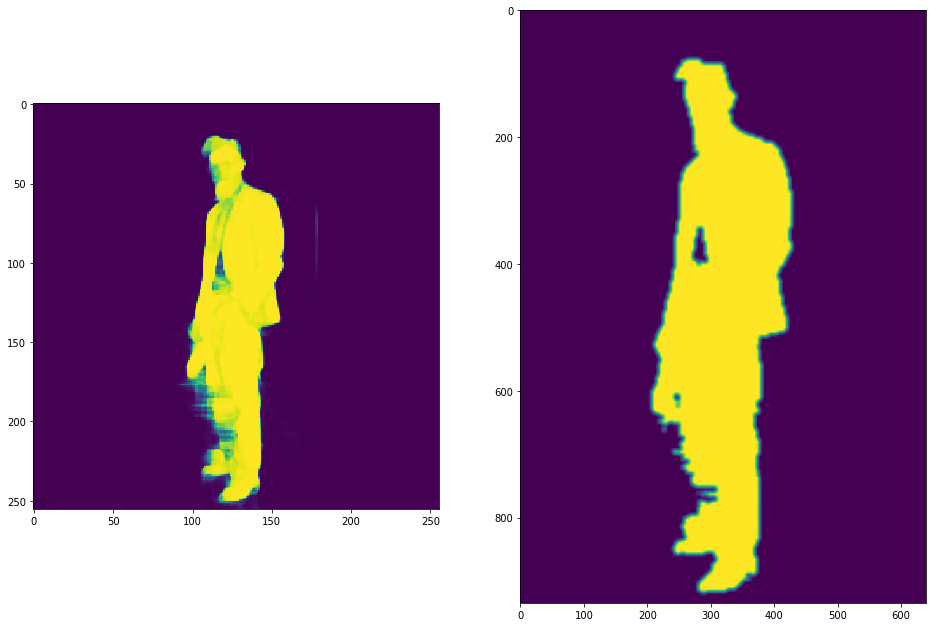

In [104]:
THRESHOLD = 0.5
EROSION = 1

def postprocess(img_ori, pred):
    h, w = img_ori.shape[:2]
    
    mask_ori = (pred.squeeze()[:, :, 1] > THRESHOLD).astype(np.uint8)
    max_size = max(h, w)
    result_mask = cv2.resize(mask_ori, dsize=(max_size, max_size))

    if h >= w:
        diff = (max_size - w) // 2
        if diff > 0:
            result_mask = result_mask[:, diff:-diff]
    else:
        diff = (max_size - h) // 2
        if diff > 0:
            result_mask = result_mask[diff:-diff, :]
        
    result_mask = cv2.resize(result_mask, dsize=(w, h))
    
    # fill holes
#     cv2.floodFill(result_mask, mask=np.zeros((h+2, w+2), np.uint8), seedPoint=(0, 0), newVal=255)
#     result_mask = cv2.bitwise_not(result_mask)
    result_mask *= 255

#     # erode image
#     element = cv2.getStructuringElement(cv2.MORPH_RECT, (2*EROSION + 1, 2*EROSION+1), (EROSION, EROSION))
#     result_mask = cv2.erode(result_mask, element)

    # smoothen edges
    result_mask = cv2.GaussianBlur(result_mask, ksize=(9, 9), sigmaX=5, sigmaY=5)
    
    return result_mask

mask = postprocess(img_ori, pred)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(pred[0, :, :, 1])
plt.subplot(1, 2, 2)
plt.imshow(mask)

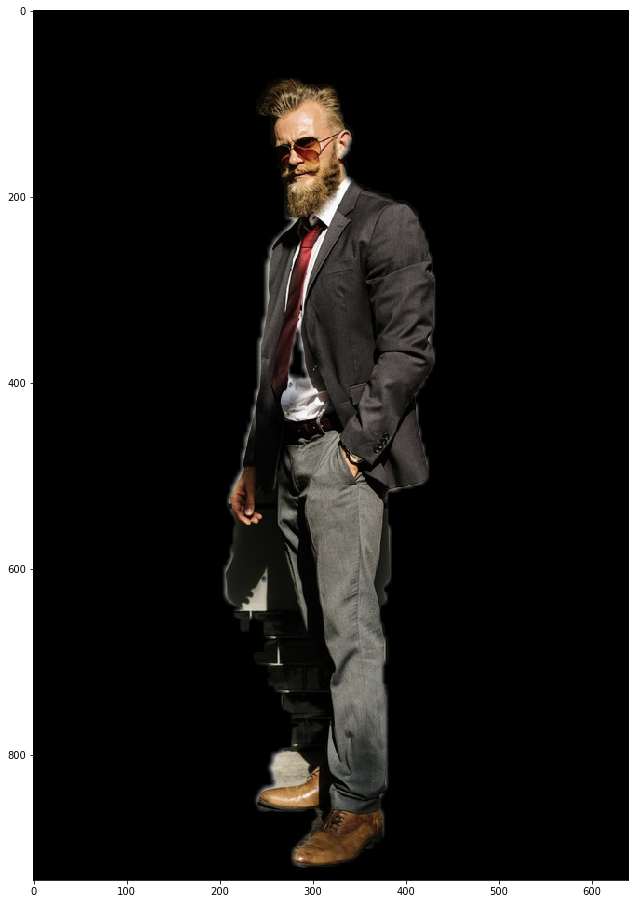

In [105]:
converted_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

result_img = cv2.subtract(converted_mask, img_ori)
result_img = cv2.subtract(converted_mask, result_img)

plt.figure(figsize=(16, 16))
plt.imshow(result_img)

(500, 333, 3) (935, 640, 3)


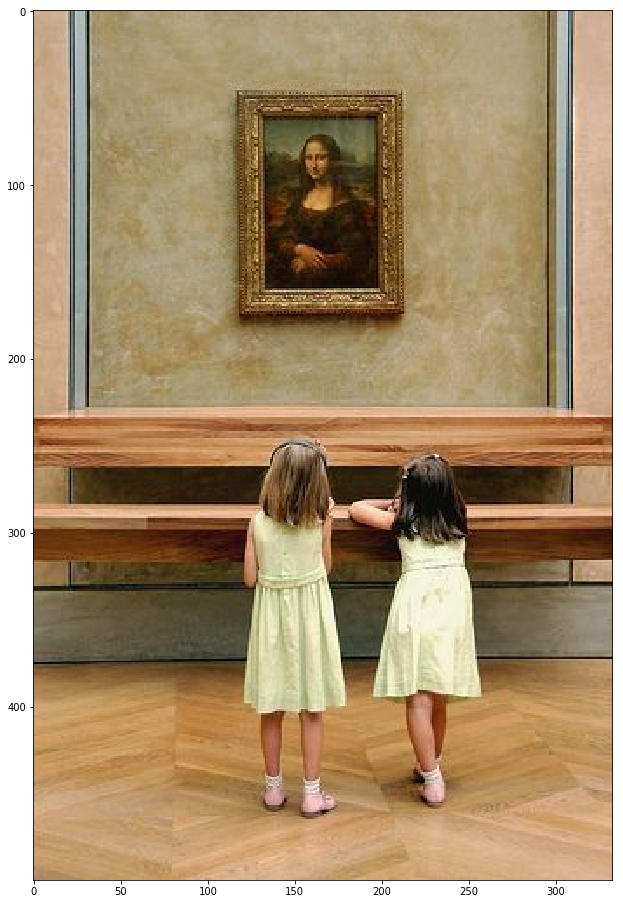

In [115]:
bg_img = cv2.imread('imgs/monalisa.jpg')
bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)

print(bg_img.shape, result_img.shape)

plt.figure(figsize=(16, 16))
plt.imshow(bg_img)

(374, 256)
(500, 333, 4)
(374, 256, 4)


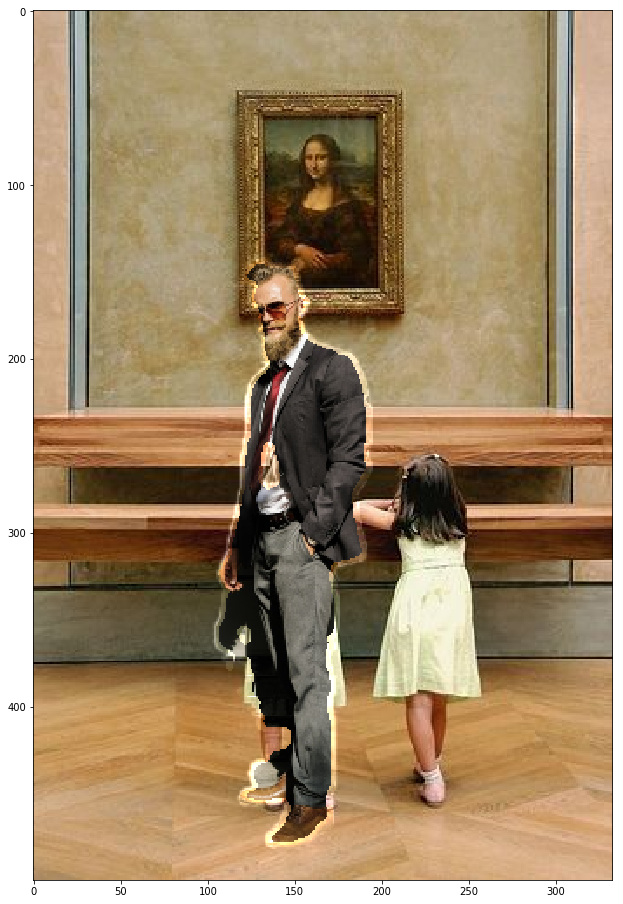

In [117]:
# overlay function
def overlay_transparent(background_img, img_to_overlay_t, mask, x, y, overlay_size=None):
    img_to_overlay_t = cv2.cvtColor(img_to_overlay_t, cv2.COLOR_RGB2RGBA)
    bg_img = background_img.copy()

    # convert 3 channels to 4 channels
    if bg_img.shape[2] == 3:
        bg_img = cv2.cvtColor(bg_img, cv2.COLOR_RGB2RGBA)

    if overlay_size is not None:
        img_to_overlay_t = cv2.resize(img_to_overlay_t.copy(), overlay_size)
        
    print(mask.shape)
    print(bg_img.shape)

    mask = cv2.medianBlur(mask, 5)

    h, w, _ = img_to_overlay_t.shape
    roi = bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)]
    
    print(roi.shape)

    img1_bg = cv2.bitwise_and(roi.copy(), roi.copy(), mask=cv2.bitwise_not(mask))
    img2_fg = cv2.bitwise_and(img_to_overlay_t, img_to_overlay_t, mask=mask)

    bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] = cv2.add(img1_bg, img2_fg)

    # convert 4 channels to 4 channels
    bg_img = cv2.cvtColor(bg_img, cv2.COLOR_RGBA2RGB)

    return bg_img

overlay_img = cv2.resize(result_img, dsize=None, fx=0.4, fy=0.4)
resized_mask = cv2.resize(mask, dsize=None, fx=0.4, fy=0.4)

out_img = overlay_transparent(bg_img, overlay_img, resized_mask, 150, 300)

plt.figure(figsize=(16, 16))
plt.imshow(out_img)